# Tema 1 - A taste for music
## Găsirea genului pentru piese

### Autori: 
* George Muraru
* Alexandru Sorici

## 1. Scopul temei



Tema are ca scop folosirea metodelor de clasificare studiate în cadrul cursului/laboratorului pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Primul pas în orice problema de data science este încărcarea și "înțelegerea" datelor.

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [232]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = True  #@param {type: "boolean"}

### Dependențe

In [233]:
!pip install pandas # needed for loading the dataset
!pip install xgboost
!pip install --upgrade scikit-learn

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg # Needed by librosa for mp3
    !pip install librosa
    !pip install tqdm # Progress bar for dowloading large file


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


### Import biblioteci

In [234]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd

### Funcții ajutătoare

In [235]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [236]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [237]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]
X = echonest.loc[train + test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]
Y = tracks.loc[train+test, ('track', 'genre_top')]



/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [238]:
# Dataset properties

# Size
print(f"Size of train dataset: ", len(X_train))
print(f"Size of test dataset: ", len(X_test))
print(f"Size of total dataset: ", len(X_train) + len(X_test))

Size of train dataset:  2000
Size of test dataset:  400
Size of total dataset:  2400


## 4. Problemă de rezolvat



Împărțim problema de rezolvat a acestei teme în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost, SVM, Naive Bayes). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori [6pct]

Pentru acest task se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans [1 pct]
  * Arbori de decizie, păduri aleatoare [1 pct]
  * XGBoost [1 pct]
  * SVM [1 pct]
  * Naive Bayes [1 pct]

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.

**Observație 2:** Algoritmii listați **nu** trebuie implementati de mana (nu obligatoriu). Este permisă utilizarea versiunilor din biblioteci cunoscute (a se vedea exemplele sugerate mai jos).


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

În scheletul temei, testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Dezvoltați clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Utilizați implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Folosiți set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Găsiți [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, raportați **cel puțin** metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Faceți rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - standardizarea datelor (vedeți Referințe).
3. Rulați KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificați utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creșteți lungmea intervalului de clustere).
5. Alegeți numărul optim de clustere și calculați **doar** *randIndex*.
6. [Opțional] Puteți analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Puteți testa să vedeți că piesele din același cluster seamănă utilizând codul de de la finalul notebook-ului.

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

**Observații Naive Bayes**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/naive_bayes.html) din bibilioteca scikit-learn.

#### Auxiliar functions

In [239]:
# Prediction
def get_Y_pred(model, X_train, Y_train, X_test):
  model.fit(X_train, Y_train)
  return model.predict(X_test)

In [240]:
# Perfomance statistics
from sklearn import metrics

def get_statistics(Y_test, Y_pred):
  accuracy = metrics.accuracy_score(Y_test, Y_pred)
  precision, recall, fscore, support = metrics.precision_recall_fscore_support(Y_test, Y_pred,average="weighted")
  print(f"Accuracy: ", accuracy)
  print(f"Recall: ", recall)
  print(f"Precision: ", precision)
  print(f"Fscore: ", fscore)
  return accuracy, precision, recall, fscore


In [241]:
# Visuals
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def print_confusion_matrix(Y_test, Y_pred, model):
  cm = confusion_matrix(Y_test, Y_pred, labels = model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
  disp.plot() 

In [242]:
# Storing results

metrics_models = []

#### KMeans

In [243]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import rand_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
print("K-Means Classifier")

clusters = [2,3,4,5,6]
silhouette_scores = {}

scaler = StandardScaler()
scaled_X_kmeans = scaler.fit_transform(X)

for no_clusters in clusters:
  kmeans_model = KMeans(n_clusters = no_clusters)
  Y_pred = kmeans_model.fit_predict(scaled_X_kmeans)
  curr_silhouette_score = silhouette_score(scaled_X_kmeans, Y_pred)
  silhouette_scores[no_clusters] = curr_silhouette_score
  # Uncomment this for plots
  # print(f"Centroids for n_clusters = ", no_clusters)
  # plt.scatter(scaled_X_kmeans[:,0], scaled_X_kmeans[:,1])
  # plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], s=300, c='red')
  # plt.show()

best_n_cluster = 0
best_score = 0

# print(silhouette_scores)
for n_cluster in silhouette_scores:
  if silhouette_scores[n_cluster] > best_score: 
    best_score = silhouette_scores[n_cluster]
    best_n_cluster = n_cluster

print(f"Best choice for clusters, based on silhoutte scores: ", best_n_cluster)

kmeans_model = KMeans(n_clusters = best_n_cluster)
Y_pred = kmeans_model.fit_predict(scaled_X_kmeans)
score  = rand_score(Y.values, Y_pred)
print(f"Rand index: ",score)

# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "KMeans"
model_performance["type"] = "baseline"
model_performance["rand_index"] = score
metrics_models.append(model_performance)


K-Means Classifier
Best choice for clusters, based on silhoutte scores:  4
Rand index:  0.6785045852438516


#### Random Forests

In [244]:
from sklearn.ensemble import RandomForestClassifier
print("Random Forest Classifier")

def baseline_random_forest():
  return RandomForestClassifier()


Random Forest Classifier


Accuracy:  0.7225
Recall:  0.7225
Precision:  0.7202986492190797
Fscore:  0.7196446188898469


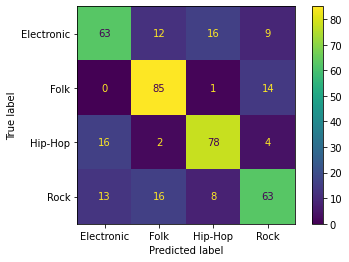

In [245]:
# Baseline Random Forest Model:
baseline_rf = baseline_random_forest()
Y_pred = get_Y_pred(baseline_rf, X_train, Y_train, X_test)
accuracy, precision, recall, fscore = get_statistics(Y_test, Y_pred)
print_confusion_matrix(Y_test, Y_pred, baseline_rf)

# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "RandomForest"
model_performance["type"] = "baseline"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)


#### XGBoost

In [246]:
from xgboost import XGBClassifier
print("XGBoost Classifier")

def baseline_xgboost():
  return XGBClassifier()


XGBoost Classifier


Accuracy:  0.73
Recall:  0.73
Precision:  0.7284619594964422
Fscore:  0.7267160822449407


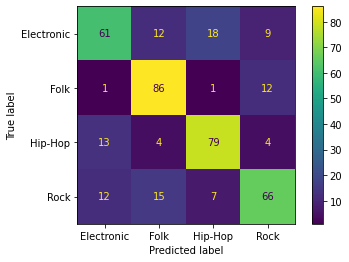

In [247]:
# Baseline XGBoost Classifier:
baseline_xgb = baseline_xgboost()
Y_pred = get_Y_pred(baseline_xgb, X_train, Y_train, X_test)
accuracy, precision, recall, fscore = get_statistics(Y_test, Y_pred)
print_confusion_matrix(Y_test, Y_pred, baseline_xgb)
# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "XGB"
model_performance["type"] = "baseline"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)


#### SVM

In [248]:
from sklearn import svm
print("SVM Classifier")
def baseline_support_vector_machine():
  return svm.SVC(kernel='linear')

SVM Classifier


Accuracy:  0.715
Recall:  0.715
Precision:  0.7148100284517366
Fscore:  0.712861244578464


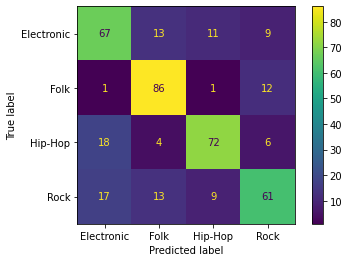

In [249]:
#Baseline SVM Classifier:
baseline_svm = baseline_support_vector_machine()
Y_pred = get_Y_pred(baseline_svm, X_train, Y_train, X_test)
accuracy, precision, recall, fscore = get_statistics(Y_test, Y_pred)
print_confusion_matrix(Y_test, Y_pred, baseline_svm)
# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "SVM"
model_performance["type"] = "baseline"
model_performance["kernel"] = "liniar"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)


#### Naive Bayes

In [250]:
from sklearn.naive_bayes import GaussianNB
print("Naive Bayes Classifier")
def baseline_naive_bayes():
  return GaussianNB()


Naive Bayes Classifier


Accuracy:  0.7
Recall:  0.7
Precision:  0.6978524326481248
Fscore:  0.6956168769647931


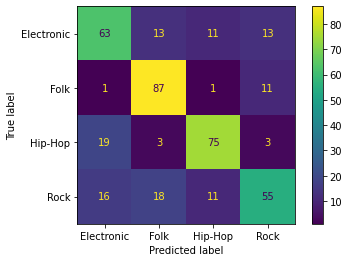

In [251]:
# Baseline Naive Bayes Classifier
baseline_nb = baseline_naive_bayes()
Y_pred = get_Y_pred(baseline_nb, X_train, Y_train, X_test)
accuracy, precision, recall, fscore = get_statistics(Y_test, Y_pred)
print_confusion_matrix(Y_test, Y_pred, baseline_nb)
# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "Naive Bayes"
model_performance["type"] = "baseline"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)


In [252]:
print(metrics_models)

[{'model': 'KMeans', 'type': 'baseline', 'rand_index': 0.6785045852438516}, {'model': 'RandomForest', 'type': 'baseline', 'accuracy': 0.7225, 'precision': 0.7202986492190797, 'recall': 0.7225, 'fscore': 0.7196446188898469}, {'model': 'XGB', 'type': 'baseline', 'accuracy': 0.73, 'precision': 0.7284619594964422, 'recall': 0.73, 'fscore': 0.7267160822449407}, {'model': 'SVM', 'type': 'baseline', 'kernel': 'liniar', 'accuracy': 0.715, 'precision': 0.7148100284517366, 'recall': 0.715, 'fscore': 0.712861244578464}, {'model': 'Naive Bayes', 'type': 'baseline', 'accuracy': 0.7, 'precision': 0.6978524326481248, 'recall': 0.7, 'fscore': 0.6956168769647931}]


### 4.2. Metode de îmbunătățire și evaluare comparativă [4pct]

Pentru fiecare algoritm, explorați metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi** [2 pct]

Aveți în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri** [2 pct]

* Evaluați variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizați grafice în care să arătați analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizați grafice în care să arătați analiza inter-algoritm a performanțelor. Faceți câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludeți valorile obținute de fiecare algoritm îmbunătățit în parte. 
* Redactați, pe seama graficelor, o analiză a acestora, evidențiind avantajele și dezavantajele fiecărui algoritm implementat.

In [253]:
from sklearn.feature_selection import SelectKBest, f_classif

# Recompute X and Y, using more features:
X_train_features = echonest.loc[train, ('echonest', ['audio_features', 'temporal_features', 'social_features'])]
X_test_features = echonest.loc[test, ('echonest',['audio_features', 'temporal_features', 'social_features'])]
X = echonest.loc[train + test, ('echonest', ['audio_features', 'temporal_features', 'social_features'])]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]
Y = tracks.loc[train + test, ('track', 'genre_top')]

X_selected = SelectKBest(f_classif, k =100).fit_transform(X, Y)
X_new = scaler.fit_transform(X_selected)

/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [254]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

def get_Y(model):
  return cross_val_predict(model, X_new, Y, cv=5)
  
def get_cross_validation_metrics(model):
  scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
  scores = cross_validate(baseline_rf, X_new, Y, cv=5, scoring=scoring)
  accuracy = scores['test_accuracy'].mean()
  precision = scores['test_precision_macro'].mean()
  recall = scores['test_recall_macro'].mean()
  fscore  = scores['test_f1_macro'].mean()
  return accuracy, precision, recall, fscore

#### Kmeans

In [255]:
for n_clusters in [4, 6, 8, 10]:
  improved_kmeans = KMeans(n_clusters = n_clusters)
  Y_pred = get_Y(improved_kmeans)
  score  = rand_score(Y.values, Y_pred)
  print(score)
  # Add to list where performances are being stored
  model_performance = {}
  model_performance["model"] = "KMeans"
  model_performance["type"] = "improved " + str(n_clusters)
  model_performance["rand_index"] = score
  metrics_models.append(model_performance)

0.6228494511602056
0.6834792274558844
0.7032655967764346
0.6985514797832431


#### Random Forests

Accuracy:  0.7420833333333334
Recall:  0.7420833333333334
Precision:  0.7464005406617531
Fscore:  0.741399347772267


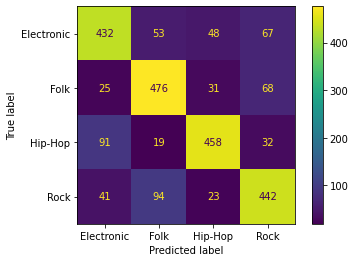

In [256]:
#RandomForests
from sklearn.metrics import plot_confusion_matrix
improved_rf = RandomForestClassifier(n_estimators=150, max_depth=50)
accuracy, precision, recall, fscore =  get_cross_validation_metrics(improved_rf)
print(f"Accuracy: ", accuracy)
print(f"Recall: ", recall)
print(f"Precision: ", precision)
print(f"Fscore: ", fscore)
Y_pred = get_Y(improved_rf)
improved_rf.fit(X_new, Y_pred)
print_confusion_matrix(Y, Y_pred, improved_rf)

# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "RandomForest"
model_performance["type"] = "improved"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)

#### XGBoost

Accuracy:  0.7470833333333333
Recall:  0.7470833333333333
Precision:  0.7516865196354309
Fscore:  0.7462976309821148


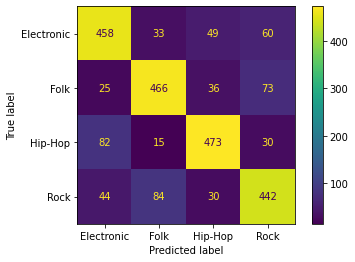

In [257]:
#XGBoost
improved_xgb = XGBClassifier(max_depth=10, n_estimators=150,objective='multi:softmax')
accuracy, precision, recall, fscore =  get_cross_validation_metrics(improved_xgb)
print(f"Accuracy: ", accuracy)
print(f"Recall: ", recall)
print(f"Precision: ", precision)
print(f"Fscore: ", fscore)
Y_pred = get_Y(improved_xgb)
improved_xgb.fit(X_new, Y_pred)
print_confusion_matrix(Y, Y_pred, improved_xgb)

# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "XGB"
model_performance["type"] = "improved"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)


#### SVM

Accuracy:  0.7454166666666666
Recall:  0.7454166666666666
Precision:  0.7515202128045789
Fscore:  0.7448443579756431


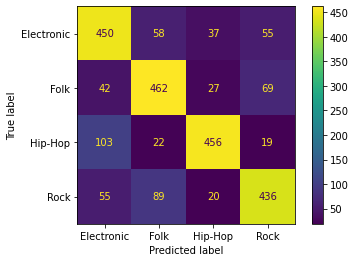

In [258]:
#SVM
improved_svm = svm.SVC(kernel='rbf', gamma='scale', decision_function_shape='ovo')
accuracy, precision, recall, fscore =  get_cross_validation_metrics(improved_svm)
print(f"Accuracy: ", accuracy)
print(f"Recall: ", recall)
print(f"Precision: ", precision)
print(f"Fscore: ", fscore)
Y_pred = get_Y(improved_svm)
improved_svm.fit(X_new, Y_pred)
print_confusion_matrix(Y, Y_pred, improved_svm)

# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "SVM"
model_performance["type"] = "improved"
model_performance["kernel"] = "rbf"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)

#### Naive Bayes

Accuracy:  0.7429166666666667
Recall:  0.7429166666666667
Precision:  0.7489827367278078
Fscore:  0.7426818545390586


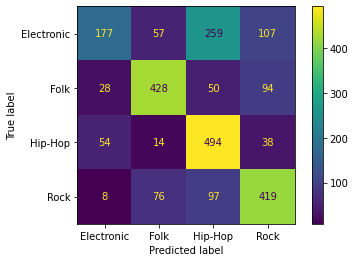

In [259]:
#Naive Bayes
improved_nb = GaussianNB()
accuracy, precision, recall, fscore =  get_cross_validation_metrics(improved_nb)
print(f"Accuracy: ", accuracy)
print(f"Recall: ", recall)
print(f"Precision: ", precision)
print(f"Fscore: ", fscore)
Y_pred = get_Y(improved_nb)
improved_nb.fit(X_new, Y_pred)
print_confusion_matrix(Y, Y_pred, improved_nb)

# Add to list where performances are being stored
model_performance = {}
model_performance["model"] = "Naive Bayes"
model_performance["type"] = "improved"
model_performance["accuracy"] = accuracy 
model_performance["precision"] = precision
model_performance["recall"]  = recall
model_performance["fscore"] = fscore
metrics_models.append(model_performance)

In [260]:
print(metrics_models)

[{'model': 'KMeans', 'type': 'baseline', 'rand_index': 0.6785045852438516}, {'model': 'RandomForest', 'type': 'baseline', 'accuracy': 0.7225, 'precision': 0.7202986492190797, 'recall': 0.7225, 'fscore': 0.7196446188898469}, {'model': 'XGB', 'type': 'baseline', 'accuracy': 0.73, 'precision': 0.7284619594964422, 'recall': 0.73, 'fscore': 0.7267160822449407}, {'model': 'SVM', 'type': 'baseline', 'kernel': 'liniar', 'accuracy': 0.715, 'precision': 0.7148100284517366, 'recall': 0.715, 'fscore': 0.712861244578464}, {'model': 'Naive Bayes', 'type': 'baseline', 'accuracy': 0.7, 'precision': 0.6978524326481248, 'recall': 0.7, 'fscore': 0.6956168769647931}, {'model': 'KMeans', 'type': 'improved 4', 'rand_index': 0.6228494511602056}, {'model': 'KMeans', 'type': 'improved 6', 'rand_index': 0.6834792274558844}, {'model': 'KMeans', 'type': 'improved 8', 'rand_index': 0.7032655967764346}, {'model': 'KMeans', 'type': 'improved 10', 'rand_index': 0.6985514797832431}, {'model': 'RandomForest', 'type': '

In [261]:
from prettytable import PrettyTable
t = PrettyTable(['Classificator', 'Type', 'Rand_index', 'Accuracy', 'Precision', 'Recall', "Fscore"])
for entry in metrics_models:
  row = []
  row.append(entry['model'])
  row.append(entry['type'])
  if 'rand_index' in entry.keys():
    row.append(entry['rand_index'])
    for i in range(0,4):
      row.append('-')
  else:
    row.append('-')
    row.append(entry['accuracy'])
    row.append(entry['precision'])
    row.append(entry['recall'])
    row.append(entry['fscore'])
  t.add_row(row)

print(t.get_string(sortby="Classificator"))

+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Classificator |     Type    |     Rand_index     |      Accuracy      |     Precision      |       Recall       |       Fscore       |
+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     KMeans    |   baseline  | 0.6785045852438516 |         -          |         -          |         -          |         -          |
|     KMeans    | improved 10 | 0.6985514797832431 |         -          |         -          |         -          |         -          |
|     KMeans    |  improved 4 | 0.6228494511602056 |         -          |         -          |         -          |         -          |
|     KMeans    |  improved 6 | 0.6834792274558844 |         -          |         -          |         -          |         -          |
|     KMeans    |  improved 8 | 0.7032655

### Intra-algorithm

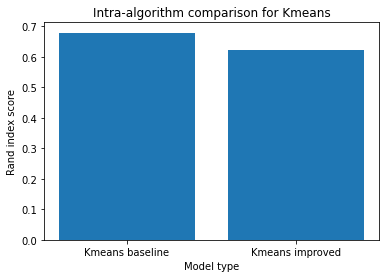

In [262]:
import matplotlib.pyplot as plt
models = ['Kmeans baseline', 'Kmeans improved']
values = [metrics_models[0]['rand_index'], metrics_models[5]['rand_index']]
plt.bar(models, values)
plt.title('Intra-algorithm comparison for Kmeans')
plt.xlabel('Model type')
plt.ylabel('Rand index score')
plt.show()

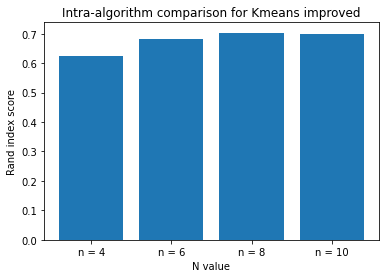

In [263]:
models = ['n = 4', 'n = 6', 'n = 8', 'n = 10']
values = [metrics_models[5]['rand_index'], metrics_models[6]['rand_index'],
           metrics_models[7]['rand_index'],metrics_models[8]['rand_index']]
plt.bar(models, values)
plt.title('Intra-algorithm comparison for Kmeans improved')
plt.xlabel('N value')
plt.ylabel('Rand index score')
plt.show()

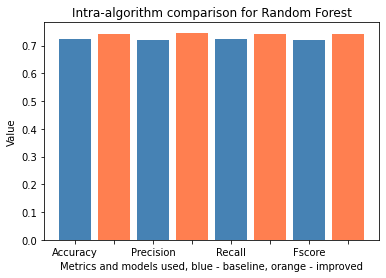

In [264]:
models = ['Accuracy', ' ', 'Precision', '  ', 'Recall', '   ', 'Fscore', '    ']
values = [metrics_models[1]['accuracy'], metrics_models[9]['accuracy'],
          metrics_models[1]['precision'], metrics_models[9]['precision'],
          metrics_models[1]['recall'], metrics_models[9]['recall'],
          metrics_models[1]['fscore'], metrics_models[9]['fscore']]
new_colors = ['steelblue','coral','steelblue','coral', 'steelblue','coral','steelblue','coral']
plt.bar(models, values, color=new_colors)
plt.title('Intra-algorithm comparison for Random Forest')
plt.xlabel('Metrics and models used, blue - baseline, orange - improved')
plt.ylabel('Value')
plt.show()

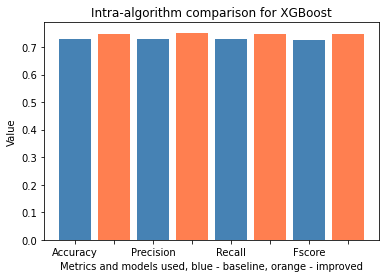

In [265]:
models = ['Accuracy', ' ', 'Precision', '  ', 'Recall', '   ', 'Fscore', '    ']
values = [metrics_models[2]['accuracy'], metrics_models[10]['accuracy'],
          metrics_models[2]['precision'], metrics_models[10]['precision'],
          metrics_models[2]['recall'], metrics_models[10]['recall'],
          metrics_models[2]['fscore'], metrics_models[10]['fscore']]
new_colors = ['steelblue','coral','steelblue','coral', 'steelblue','coral','steelblue','coral']
plt.bar(models, values, color=new_colors)
plt.title('Intra-algorithm comparison for XGBoost')
plt.xlabel('Metrics and models used, blue - baseline, orange - improved')
plt.ylabel('Value')
plt.show()

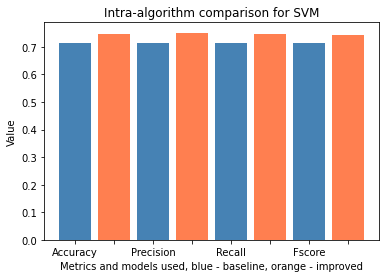

In [266]:
models = ['Accuracy', ' ', 'Precision', '  ', 'Recall', '   ', 'Fscore', '    ']
values = [metrics_models[3]['accuracy'], metrics_models[11]['accuracy'],
          metrics_models[3]['precision'], metrics_models[11]['precision'],
          metrics_models[3]['recall'], metrics_models[11]['recall'],
          metrics_models[3]['fscore'], metrics_models[11]['fscore']]
new_colors = ['steelblue','coral','steelblue','coral', 'steelblue','coral','steelblue','coral']
plt.bar(models, values, color=new_colors)
plt.title('Intra-algorithm comparison for SVM')
plt.xlabel('Metrics and models used, blue - baseline, orange - improved')
plt.ylabel('Value')
plt.show()

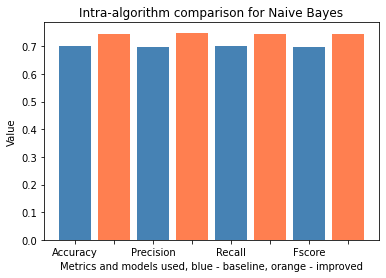

In [267]:
models = ['Accuracy', ' ', 'Precision', '  ', 'Recall', '   ', 'Fscore', '    ']
values = [metrics_models[4]['accuracy'], metrics_models[12]['accuracy'],
          metrics_models[4]['precision'], metrics_models[12]['precision'],
          metrics_models[4]['recall'], metrics_models[12]['recall'],
          metrics_models[4]['fscore'], metrics_models[12]['fscore']]
new_colors = ['steelblue','coral','steelblue','coral', 'steelblue','coral','steelblue','coral']
plt.bar(models, values, color=new_colors)
plt.title('Intra-algorithm comparison for Naive Bayes')
plt.xlabel('Metrics and models used, blue - baseline, orange - improved')
plt.ylabel('Value')
plt.show()

### Inter-algorithm

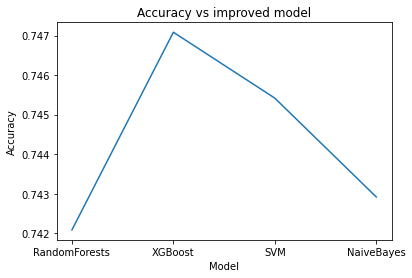

In [268]:
models = ['RandomForests', 'XGBoost', 'SVM', 'NaiveBayes']
accuracy = [metrics_models[9]['accuracy'], metrics_models[10]['accuracy'],
            metrics_models[11]['accuracy'], metrics_models[12]['accuracy']]

plt.plot(models, accuracy)
plt.title('Accuracy vs improved model')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

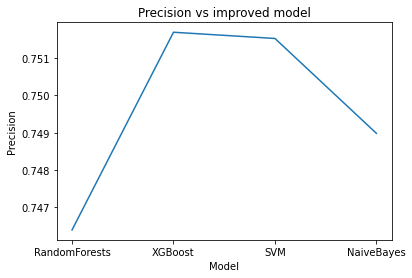

In [269]:
models = ['RandomForests', 'XGBoost', 'SVM', 'NaiveBayes']
precision = [metrics_models[9]['precision'], metrics_models[10]['precision'],
            metrics_models[11]['precision'], metrics_models[12]['precision']]

plt.plot(models, precision)
plt.title('Precision vs improved model')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.show()

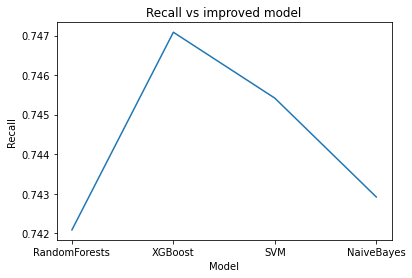

In [270]:
models = ['RandomForests', 'XGBoost', 'SVM', 'NaiveBayes']
recall = [metrics_models[9]['recall'], metrics_models[10]['recall'],
            metrics_models[11]['recall'], metrics_models[12]['recall']]

plt.plot(models, recall)
plt.title('Recall vs improved model')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.show()

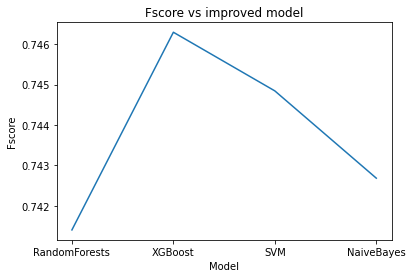

In [271]:
models = ['RandomForests', 'XGBoost', 'SVM', 'NaiveBayes']
fscore = [metrics_models[9]['fscore'], metrics_models[10]['fscore'],
            metrics_models[11]['fscore'], metrics_models[12]['fscore']]

plt.plot(models, fscore)
plt.title('Fscore vs improved model')
plt.xlabel('Model')
plt.ylabel('Fscore')
plt.show()

## 5. Mențiuni

**Pentru rezolvarea task-urilor puteți folosi orice bibliotecă doriți.**

În scheletul temei, datele sunt încărcate folosind biblioteca [pandas](https://pandas.pydata.org/), însă puteți utiliza orice bibliotecă doriți.

**Algoritmii nu trebuie implementați de mână.**

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

In [272]:
track_test = tracks[test].sample(1)
title = track_test[('track', 'title')].values[0]
genre = track_test[('track', 'genre_top')].values[0]
print(f"Song\n\ttitle: {title}\n\tgenre {genre}")

song_path = get_song_path(track_test.index.values[0])
song, rate = librosa.load(song_path)
ipd.Audio(song, rate=rate)

Song
	title: So Wrong
	genre Rock


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

